# Model One Logistic Regression

This Notbook should predict whether a certain path in a model should be animated or not based on the embedding and additional features created.

For training we are using self-labeled data.

In [96]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### 1. Load and map data

Delete rows of logo_id (provided through filename) and order_id (not important)

In [266]:
target = pd.read_csv("../data/model_one/label.csv")
target["logo"] = target["logo_id"].apply(lambda row: "logo_" + str(row)) # set up logo numeration for labeling
target = target.drop(['logo_id','order_id','filename'], axis = 1) # drop unnecessary attributes
target['animation_id'] = target['animation_id'].astype(int) #transform animation_id to int for mapping with feature table
target=target.rename(columns={"logo": "filename"}) # transform for feature mapping
target.head()

,animation_id,animate,filename
0,5,0.5625,logo_0
1,0,0.5625,logo_0
2,2,0.5625,logo_0
3,4,0.6250,logo_0
4,3,0.5000,logo_0


Load an match of training data

In [269]:
X_train = pd.read_csv("../data/X_train_model1.csv")
X_train = X_train.drop("Unnamed: 0",axis=1) # Delete unneccessary columnd which was copied as indice
X_train.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
0,logo_0,0,-8.423252,6.659946,-0.939508,8.172318,2.592043,-0.152183,-5.213738,-1.969898,...,0.0,0.0,0.0,0.0,0.488551,0.651937,0.267174,0.355178,10,7
1,logo_0,1,10.430962,8.788332,-1.172750,5.548588,4.197551,0.896091,-3.633365,-0.105815,...,0.0,0.0,0.0,0.0,0.391017,0.458231,0.706957,0.577049,10,7
2,logo_0,3,2.835144,3.689274,-0.448358,2.783648,5.923646,0.482464,-0.736975,0.571085,...,0.0,0.0,0.0,0.0,0.391042,0.458231,0.315928,0.577049,10,4
3,logo_0,2,-0.818861,-8.132976,-3.242880,5.503012,3.614000,4.153876,1.869076,5.564114,...,0.0,0.0,0.0,0.0,0.769168,0.318733,0.511441,0.840633,10,5
4,logo_0,4,4.431674,8.372319,-0.187969,5.491306,4.576774,2.358074,-3.036878,2.053856,...,0.0,0.0,0.0,0.0,0.573461,0.306260,0.511553,0.194615,10,4


Merge Darframe based on the paths for which we have an annotation (df)

In [270]:
new_df = pd.merge(target, X_train,  how='left', left_on=['filename','animation_id'], right_on = ['filename','animation_id'])
new_df.head(5)

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
0,5,0.5625,logo_0,8.664970,11.888564,-3.283349,6.933374,6.104668,1.861186,2.936783,...,0.0,0.0,0.0,0.0,0.488551,0.651931,0.755725,0.355181,10.0,7.0
1,0,0.5625,logo_0,-8.423252,6.659946,-0.939508,8.172318,2.592043,-0.152183,-5.213738,...,0.0,0.0,0.0,0.0,0.488551,0.651937,0.267174,0.355178,10.0,7.0
2,2,0.5625,logo_0,-0.818861,-8.132976,-3.242880,5.503012,3.614000,4.153876,1.869076,...,0.0,0.0,0.0,0.0,0.769168,0.318733,0.511441,0.840633,10.0,5.0
3,4,0.6250,logo_0,4.431674,8.372319,-0.187969,5.491306,4.576774,2.358074,-3.036878,...,0.0,0.0,0.0,0.0,0.573461,0.306260,0.511553,0.194615,10.0,4.0
4,3,0.5000,logo_0,2.835144,3.689274,-0.448358,2.783648,5.923646,0.482464,-0.736975,...,0.0,0.0,0.0,0.0,0.391042,0.458231,0.315928,0.577049,10.0,4.0


Delete rows in which we have NaN embeddings

In [271]:
new_df = new_df.dropna(axis=0,thresh=4)

Load Test data set and drop same features

In [276]:
X_test = pd.read_csv("../data/X_test_model1.csv")
X_test = X_test.drop("Unnamed: 0",axis=1)
X_test.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
0,logo_147,0,-9.504045,-9.003273,1.315889,1.149846,-0.131426,2.216907,0.065995,-2.285678,...,0.0,0.0,0.0,0.0,0.074259,0.540364,0.060423,0.547507,19,39
1,logo_147,1,-7.322800,3.480343,6.454743,-1.705780,0.222926,-0.200275,-0.147428,0.072568,...,0.0,0.0,0.0,0.0,0.025447,0.357524,0.177258,0.461866,19,8
2,logo_147,10,-11.592114,1.553832,-4.058248,0.999512,-0.771203,0.589419,-0.344601,0.555307,...,0.0,0.0,0.0,0.0,0.017044,0.085221,0.183468,0.182756,19,6
3,logo_147,12,1.311852,-1.372035,-1.438357,-1.242609,-0.015314,-1.876224,-0.656107,-1.036269,...,0.0,0.0,0.0,0.0,0.055225,0.207291,0.502015,0.221658,19,6
4,logo_147,2,-5.727002,2.818813,7.913018,-0.386320,-0.708162,-0.041485,-1.926894,-0.390873,...,0.0,0.0,0.0,0.0,0.047815,0.364758,0.131559,0.458241,19,5


In [277]:
test_df = pd.merge(target, X_test,  how='left', left_on=['filename','animation_id'], right_on = ['filename','animation_id'])
test_df = test_df.dropna(axis=0,thresh=4)
test_df.head()

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
1150,11,1.0,logo_147,2.859270,5.735336,8.452274,2.243156,-1.396212,-2.589806,-0.654833,...,0.0,0.0,0.0,0.0,0.172791,0.610861,0.418358,0.576557,19.0,6.0
1151,3,0.0,logo_147,-3.452108,-4.527767,10.290763,1.756679,-0.524896,0.992716,-2.800216,...,0.0,0.0,0.0,0.0,0.113487,0.364979,0.259243,0.458139,19.0,239.0
1152,5,0.0,logo_147,14.291578,0.396941,0.477692,0.057385,-0.311796,2.194681,0.191215,...,0.0,0.0,0.0,0.0,0.074262,0.540355,0.832217,0.547495,19.0,13.0
1153,4,0.0,logo_147,1.601089,-4.384979,2.145719,-1.769461,0.387045,2.147506,-0.415926,...,0.0,0.0,0.0,0.0,0.074263,0.540364,0.595574,0.547499,19.0,26.0
1154,0,0.0,logo_147,-9.504045,-9.003273,1.315889,1.149846,-0.131426,2.216907,0.065995,...,0.0,0.0,0.0,0.0,0.074259,0.540364,0.060423,0.547507,19.0,39.0


### 2. Feature Selection

We want to take a look on the correlation matrix to identify features which can be excluded upfront.

C:\Users\timhb\Anaconda3\envs\automatically_animate_logos\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


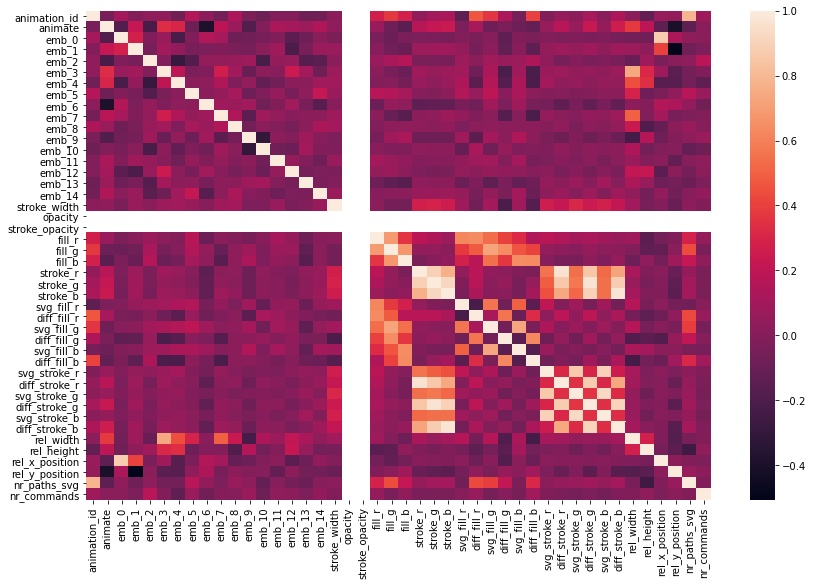

In [278]:
corrMatrix = new_df.corr()
f = plt.figure(figsize=(14, 9))
sn.heatmap(corrMatrix, annot=False)
f.show()

Since both _opacity_ and _stroke_opacity_ are always of value *one* we exclude them.

In [279]:
new_df = new_df.drop(['opacity','stroke_opacity'], axis = 1, errors='ignore')
test_df = test_df.drop(['opacity','stroke_opacity'], axis = 1, errors='ignore')

Check for features that have a to high correlation

In [280]:
correlated_features = set()
correlation_matrix = new_df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [281]:
corr_features = list(correlated_features)

Features which are correlated to strong are getting ignored upfront

In [282]:
new_df = new_df.drop(corr_features,axis=1,errors='ignore')

In [283]:
test_df = test_df.drop(corr_features,axis=1,errors='ignore')

### 3. Preprocessing

Add function that replaces animate decision with binary integrer values

In [284]:
new_df['animate']=[0 if x < 0.5 else 1 for x in new_df['animate']]
test_df['animate']=[0 if x < 0.5 else 1 for x in test_df['animate']]

### Perform split between features and target

In [285]:
x_train = new_df.drop(['filename','animation_id','animate'],axis=1,errors='ignore')
y_train = new_df['animate']
x_test = test_df.drop(['filename','animation_id','animate'],axis=1,errors='ignore')
y_test = test_df['animate']

### Implement the model

Now we perform the actual regression

In [287]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

C:\Users\timhb\Anaconda3\envs\automatically_animate_logos\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [288]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


### Results

In [263]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       266
           1       0.71      0.79      0.74        89

    accuracy                           0.86       355
   macro avg       0.82      0.84      0.83       355
weighted avg       0.87      0.86      0.87       355

